**This ShuffleNetV2 Model is implemented by Group 1 Member, Jin Ziqi(57854391)**


**ShuffleNet Model Description**

ShuffleNet is a Convolutional Neural Network (CNN) model introduced by researchers from Megvii (Face++) to address the challenges of efficiency and accuracy in mobile and embedded device applications. This model is well-known for its lightweight architecture and practical implementation, achieving significant computational efficiency while maintaining competitive accuracy on image classification tasks such as ImageNet.

The architecture uses channel splitting and channel shuffling mechanisms to optimize feature map computation and ensure information sharing across channels. ShuffleNet employs convolutional layers with grouped convolutions and pointwise convolutions (1×1) to reduce computational overhead. Additionally, depthwise separable convolutions (3×3) are integrated into the design to further enhance spatial feature extraction with minimal computation.

ShuffleNet features stages that utilize ShuffleBlocks for modular design. Each ShuffleBlock includes:

A channel split operation to divide input channels into separate processing branches.
A sequence of grouped or depthwise convolutions for efficient feature computation.
A channel shuffle operation to ensure proper intermixing of feature channels.
The network is highly scalable, offering multiple configurations such as ShuffleNet 0.5x, 1.0x, 1.5x, and 2.0x, which differ in the number of output channels and computational complexity, making it adaptable to various hardware environments. The final stage of the architecture typically includes a global average pooling layer followed by a fully connected layer and a SoftMax activation function for classification.

ShuffleNet’s key innovation lies in balancing accuracy and efficiency, achieving impressive performance on mobile devices and resource-constrained platforms.


In [ ]:
# Install the torchinfo package for showing the network architecture information
!pip install torchinfo -qqq


In [ ]:
# Import the necessary libraries for working with CIFART-10 dataset and PyTorch.
import torch
import torchvision
from torchvision import datasets,transforms
import torch.nn as nn
import torch.nn.functional as F
from torch import nn,optim,no_grad
from torch.utils.data import DataLoader
import torch.optim.lr_scheduler as lr_scheduler
from torchinfo import summary

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
import pickle
import sys
import time

import torch as t
import torch.nn as nn
import torch.nn.functional as F
import math

In [ ]:

# To configure the usage of a GPU (cuda) or MPS (Apple) if either of them is available
has_mps = torch.backends.mps.is_built()
device = "cuda" if torch.cuda.is_available() else "mps" if has_mps else "cpu"
print(f"Python versoin: {sys.version_info.major, sys.version_info.minor, sys.version_info.micro}")
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

Python versoin: (3, 10, 12)
PyTorch version: 2.5.1+cu121
Device: cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

train_path = '/content/drive/MyDrive/Colab Notebooks/trainset'
test_path = '/content/drive/MyDrive/Colab Notebooks/testset'


In [ ]:

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from torchvision import datasets, transforms

# 下载并安装中文字体
!apt-get -qq install -y fonts-noto-cjk

import matplotlib.font_manager as fm

# 查找可用的 Noto 字体
font_dirs = fm.findSystemFonts(fontpaths=None)
print("Available fonts:", font_dirs)

# 设置使用的中文字体
font_path = "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"  # 正确的字体路径
font_prop = fm.FontProperties(fname=font_path)


Selecting previously unselected package fonts-noto-cjk.
(Reading database ... 123630 files and directories currently installed.)
Preparing to unpack .../fonts-noto-cjk_1%3a20220127+repack1-1_all.deb ...
Unpacking fonts-noto-cjk (1:20220127+repack1-1) ...
Setting up fonts-noto-cjk (1:20220127+repack1-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
Available fonts: ['/usr/share/fonts/truetype/liberation/LiberationSansNarrow-BoldItalic.ttf', '/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc', '/usr/share/fonts/truetype/humor-sans/Humor-Sans.ttf', '/usr/share/fonts/truetype/liberation/LiberationSans-Italic.ttf', '/usr/share/fonts/truetype/liberation/LiberationSans-BoldItalic.ttf', '/usr/share/fonts/truetype/liberation/LiberationMono-BoldItalic.ttf', '/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf', '/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf', '/usr/share/fonts/truetype/liberation/LiberationSerif-Bold.ttf', '/usr/share/fon

In [ ]:
from torchvision import transforms


train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 定义测试集的 transforms，不使用数据增强，仅进行预处理
test_transform = transforms.Compose([
    transforms.Resize(256),  # 将图像缩放到 256 像素
    transforms.CenterCrop(224),  # 中心裁剪为 224x224 大小
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])




# 加载解压后的数据集
train_set = datasets.ImageFolder(root=train_path, transform=train_transform)
test_set = datasets.ImageFolder(root=test_path, transform=test_transform)

# 创建数据加载器
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)


# Define the classes if they are known
classes = [
    '云芝', '冬菇', '冬虫夏草','出血齿菌', '变绿红菇', '大青褶伞', '大鹿花菌', '宽鳞多孔菌',
    '尾花笼头菌', '干巴菌','恶魔雪茄蘑菇', '杏鮑菇', '欧洲黑木耳','毒丝盖伞', '毒蕈', '毒蝇伞', '毛头鬼伞',
    '灵芝','牛舌菌', '狭头小菇', '猴头菇', '硫黄菌', '竹荪', '粉红枝瑚菌', '粪生黑蛋巢菌',
    '紫蜡蘑','綠蓋粉孢牛肝菌', '红笼头菌', '红紫柄小菇' ,'细褐鳞蘑菇', '羊肚菌', '美味牛肝菌','蓝绿乳菇', '裂褶菌',
    '赭红拟口蘑', '金黃鵝膏菌','鳞柄白鹅膏','鹿蕊', '黄裙竹荪', '黑松露'
]


# Check dataset loading
print("Number of training samples:", len(train_set))
print("Number of test samples:", len(test_set))
print("Classes:", classes)
print("Class to index mapping:", train_set.class_to_idx)
print(len(classes))




Number of training samples: 7548
Number of test samples: 1367
Classes: ['云芝', '冬菇', '冬虫夏草', '出血齿菌', '变绿红菇', '大青褶伞', '大鹿花菌', '宽鳞多孔菌', '尾花笼头菌', '干巴菌', '恶魔雪茄蘑菇', '杏鮑菇', '欧洲黑木耳', '毒丝盖伞', '毒蕈', '毒蝇伞', '毛头鬼伞', '灵芝', '牛舌菌', '狭头小菇', '猴头菇', '硫黄菌', '竹荪', '粉红枝瑚菌', '粪生黑蛋巢菌', '紫蜡蘑', '綠蓋粉孢牛肝菌', '红笼头菌', '红紫柄小菇', '细褐鳞蘑菇', '羊肚菌', '美味牛肝菌', '蓝绿乳菇', '裂褶菌', '赭红拟口蘑', '金黃鵝膏菌', '鳞柄白鹅膏', '鹿蕊', '黄裙竹荪', '黑松露']
Class to index mapping: {'云芝': 0, '冬菇': 1, '冬虫夏草': 2, '出血齿菌': 3, '变绿红菇': 4, '大青褶伞': 5, '大鹿花菌': 6, '宽鳞多孔菌': 7, '尾花笼头菌': 8, '干巴菌': 9, '恶魔雪茄蘑菇': 10, '杏鮑菇': 11, '欧洲黑木耳': 12, '毒丝盖伞': 13, '毒蕈': 14, '毒蝇伞': 15, '毛头鬼伞': 16, '灵芝': 17, '牛舌菌': 18, '狭头小菇': 19, '猴头菇': 20, '硫黄菌': 21, '竹荪': 22, '粉红枝瑚菌': 23, '粪生黑蛋巢菌': 24, '紫蜡蘑': 25, '綠蓋粉孢牛肝菌': 26, '红笼头菌': 27, '红紫柄小菇': 28, '细褐鳞蘑菇': 29, '羊肚菌': 30, '美味牛肝菌': 31, '蓝绿乳菇': 32, '裂褶菌': 33, '赭红拟口蘑': 34, '金黃鵝膏菌': 35, '鳞柄白鹅膏': 36, '鹿蕊': 37, '黄裙竹荪': 38, '黑松露': 39}
40


40


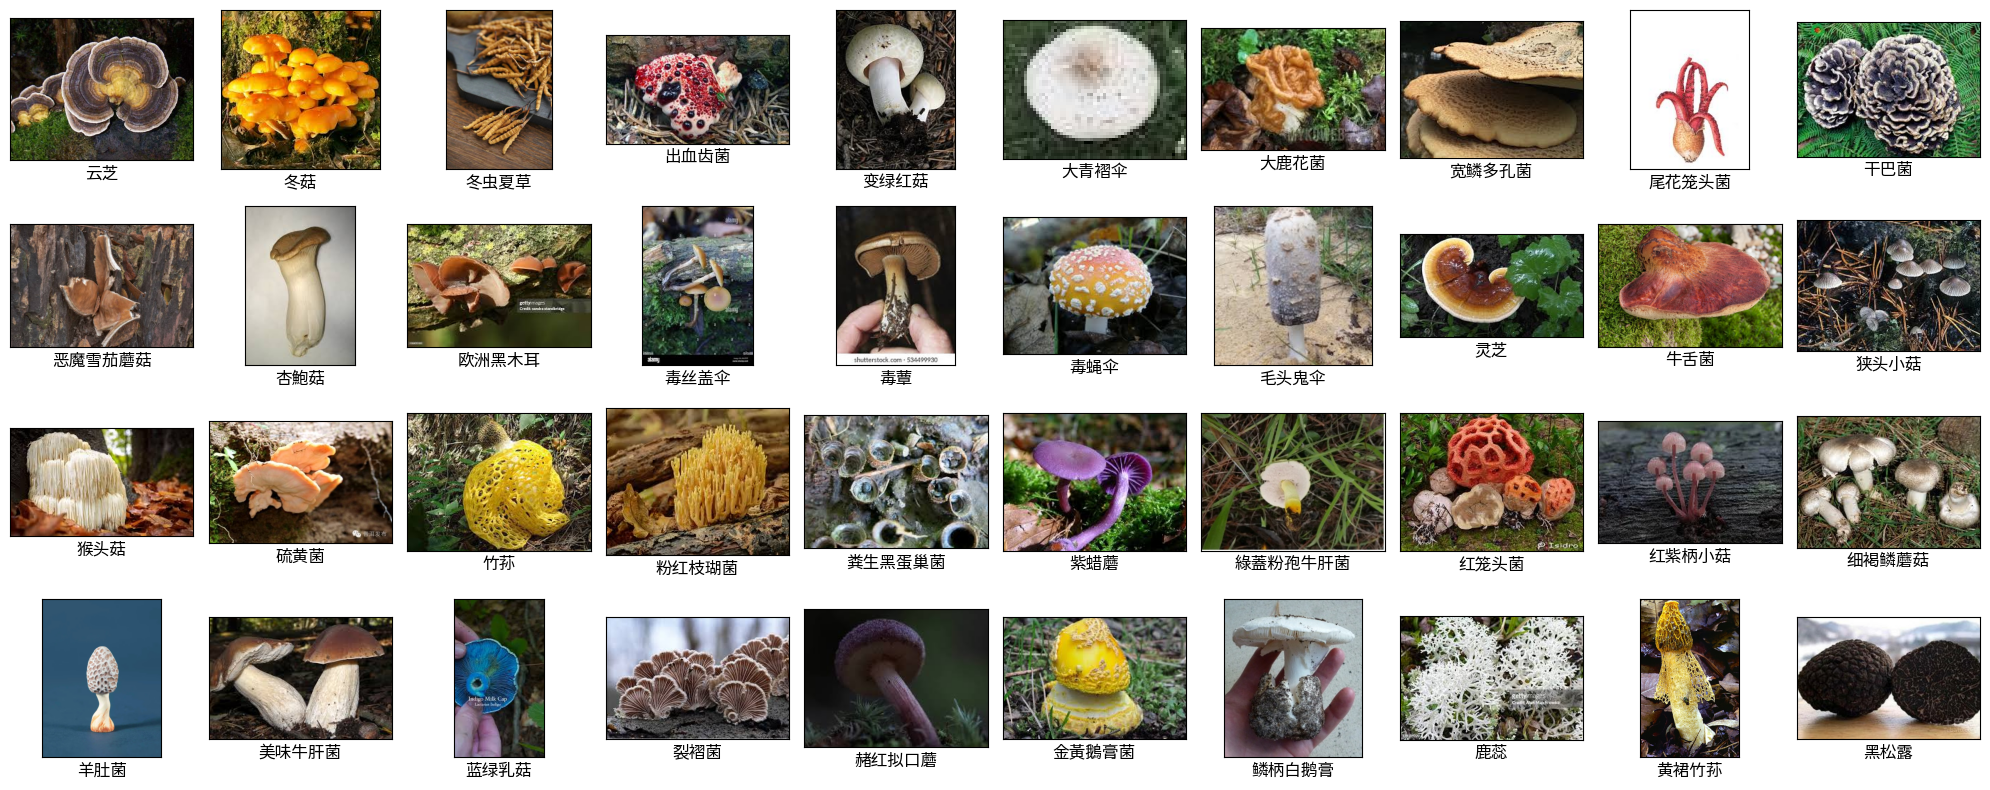

In [ ]:

# 获取类别数
num_classes = len(classes)
classes = train_set.classes
print(len(train_set.classes))

# 确保 classes 和 train_set.class_to_idx 对应
class_idx_to_chinese = {v: classes[v] for v in range(len(classes))}

# 每个类别选择一张示例图像
sample_images = []
for label in range(len(classes)):
    # 找到第一个属于当前类别的图像
    for path, target in train_set.imgs:
        if target == label:
            img = Image.open(path).convert("RGB")  # 转换为RGB
            sample_images.append((img, class_idx_to_chinese[label]))  # 用中文名作为标签
            break

# 设置显示网格
fig, axes = plt.subplots(4, 10, figsize=(20, 8))
i = 0
for row in axes:
    for axis in row:
        axis.set_xticks([])
        axis.set_yticks([])
        if i < len(sample_images):
            img, label = sample_images[i]
            axis.set_xlabel(label, fontsize=12, fontproperties=font_prop)  # 中文标签
            axis.imshow(img)
        else:
            axis.axis('off')  # 如果样本不足，关闭多余的子图框
        i += 1

plt.tight_layout()
plt.show()


**Define CNN Model**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the channel shuffle function
def channel_shuffle(x, groups=2):
    batch_size, channels, width, height = x.shape
    group_channels = channels // groups
    # Reshape the input tensor to split channels into groups
    x = x.view(batch_size, groups, group_channels, width, height)
    # Transpose to shuffle the channels
    x = torch.transpose(x, 1, 2).contiguous()
    # Reshape back to the original format
    x = x.view(batch_size, -1, width, height)
    return x

# Define 1x1 convolution + BatchNorm + ReLU
def conv_1x1_bn(in_channels, out_channels, stride=1):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 1, stride, 0, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

# Define 3x3 convolution + BatchNorm + ReLU
def conv_bn(in_channels, out_channels, stride=2):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

# Define the ShuffleBlock
class ShuffleBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=False):
        super(ShuffleBlock, self).__init__()
        self.downsample = downsample
        half_channels = out_channels // 2
        if downsample:
            # Branch 1 for downsampling
            self.branch1 = nn.Sequential(
                nn.Conv2d(in_channels, in_channels, 3, 2, 1, groups=in_channels, bias=False),  # Depthwise convolution
                nn.BatchNorm2d(in_channels),
                nn.Conv2d(in_channels, half_channels, 1, 1, 0, bias=False),  # Pointwise convolution
                nn.BatchNorm2d(half_channels),
                nn.ReLU(inplace=True)
            )
            # Branch 2 for downsampling
            self.branch2 = nn.Sequential(
                nn.Conv2d(in_channels, half_channels, 1, 1, 0, bias=False),  # Pointwise convolution
                nn.BatchNorm2d(half_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(half_channels, half_channels, 3, 2, 1, groups=half_channels, bias=False),  # Depthwise convolution
                nn.BatchNorm2d(half_channels),
                nn.Conv2d(half_channels, half_channels, 1, 1, 0, bias=False),  # Pointwise convolution
                nn.BatchNorm2d(half_channels),
                nn.ReLU(inplace=True)
            )
        else:
            assert in_channels == out_channels
            # Branch 2 for no downsampling
            self.branch2 = nn.Sequential(
                nn.Conv2d(half_channels, half_channels, 1, 1, 0, bias=False),  # Pointwise convolution
                nn.BatchNorm2d(half_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(half_channels, half_channels, 3, 1, 1, groups=half_channels, bias=False),  # Depthwise convolution
                nn.BatchNorm2d(half_channels),
                nn.Conv2d(half_channels, half_channels, 1, 1, 0, bias=False),  # Pointwise convolution
                nn.BatchNorm2d(half_channels),
                nn.ReLU(inplace=True)
            )

    def forward(self, x):
        if self.downsample:
            # Concatenate results from both branches
            out = torch.cat((self.branch1(x), self.branch2(x)), 1)
        else:
            # Split input into two parts and process one part
            channels = x.shape[1]
            half = channels // 2
            x1 = x[:, :half, :, :]  # First half of the input
            x2 = x[:, half:, :, :]  # Second half of the input
            out = torch.cat((x1, self.branch2(x2)), 1)
        # Apply channel shuffle
        return channel_shuffle(out, 2)

# Define the ShuffleNet V2 model
class ShuffleNet2(nn.Module):
    def __init__(self, num_classes, input_size=224, net_type=2, dropout_rate=0.5):
        super(ShuffleNet2, self).__init__()
        assert input_size % 32 == 0

        # Define the number of channels for each network type
        self.stage_repeat_num = [6, 10, 6]  # Number of repetitions for each stage
        if net_type == 0.5:
            self.out_channels = [3, 24, 48, 96, 192, 1024]
        elif net_type == 1:
            self.out_channels = [3, 24, 116, 232, 464, 1024]
        elif net_type == 1.5:
            self.out_channels = [3, 24, 176, 352, 704, 1024]
        elif net_type == 2:
            self.out_channels = [3, 24, 244, 488, 976, 2048]
        else:
            raise ValueError("net_type must be one of 0.5, 1, 1.5, or 2")

        # First convolutional layer
        self.conv1 = nn.Conv2d(3, self.out_channels[1], 3, 2, 1)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        in_channels = self.out_channels[1]

        # Build ShuffleBlock stages
        self.stages = []
        for stage_idx in range(len(self.stage_repeat_num)):
            out_channels = self.out_channels[2 + stage_idx]
            repeat_num = self.stage_repeat_num[stage_idx]
            for i in range(repeat_num):
                downsample = (i == 0)  # Downsample only in the first block of each stage
                self.stages.append(ShuffleBlock(in_channels, out_channels, downsample=downsample))
                in_channels = out_channels
        self.stages = nn.Sequential(*self.stages)

        # Additional convolutional layer before conv5
        in_channels = self.out_channels[-2]
        self.extra_conv = conv_bn(in_channels, in_channels * 2, stride=1)
        in_channels *= 2
        out_channels = self.out_channels[-1]

        # Final convolutional layer
        self.conv5 = conv_1x1_bn(in_channels, out_channels, 1)
        self.g_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Dropout layer
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(out_channels, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.stages(x)
        x = self.extra_conv(x)  # Pass through the additional convolutional layer
        x = self.conv5(x)
        x = self.g_avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x


In [ ]:
# 初始化模型
model = ShuffleNet2(num_classes)
model.to(device);  # 将模型移动到指定设备（例如 GPU）#加分号抑制结构输出

Train the model

In [ ]:
from prettytable import PrettyTable
import torch.nn as nn

# 创建 PrettyTable 实例
table = PrettyTable()
table.field_names = ["Layer", "Sub-Layer", "Details"]

# 递归函数，获取模型的子层
def get_model_structure(model, parent_name=""):
    for name, module in model.named_children():
        full_name = f"{parent_name}.{name}" if parent_name else name
        if list(module.children()):  # 如果该模块还有子层
            get_model_structure(module, full_name)
        else:  # 基础层直接添加到表中
            table.add_row([parent_name, name, str(module)])

# 调用函数构建表格
get_model_structure(model)

# 打印模型结构
print("Model Structure:")
print(table)


Model Structure:
+-------------------+------------+---------------------------------------------------------------------------------------------+
|       Layer       | Sub-Layer  |                                           Details                                           |
+-------------------+------------+---------------------------------------------------------------------------------------------+
|                   |   conv1    |               Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))              |
|                   |  maxpool   |          MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)         |
|  stages.0.branch1 |     0      |   Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)  |
|  stages.0.branch1 |     1      |       BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)       |
|  stages.0.branch1 |     2      |                Conv2d(24, 122, kernel_size=(1

In [ ]:

# Create a Models folder to store the checkpoints
!mkdir Models

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
# Specify Loss/Cost function
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5) # 每10个epoch学习率减半

In [ ]:
EPOCHS = 100
loss_hist, acc_hist = [], []  # 存储训练损失和准确率
loss_hist_test, acc_hist_test = [], []  # 存储验证损失和准确率

print("Training was started.\n")

for epoch in range(1, EPOCHS + 1):
    time_ckpt = time.time()
    print("EPOCH:", epoch, end=" ")
    running_loss = 0.0
    correct = 0

    # 训练循环
    model.train()  # 确保模型处于训练模式
    for data in train_loader:
        batch, labels = data
        batch, labels = batch.to(device), labels.to(device)

        optimizer.zero_grad()  # 清空梯度
        outputs = model(batch)  # 前向传播
        loss = criterion(outputs, labels)  # 计算损失
        loss.backward()  # 反向传播（计算梯度）
        optimizer.step()  # 更新模型参数

        # 计算训练统计
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()



    avg_loss = running_loss / len(train_set)  # 每个 epoch 的平均训练损失
    avg_acc = correct / len(train_set)  # 每个 epoch 的平均训练准确率
    loss_hist.append(avg_loss)
    acc_hist.append(avg_acc)

    # 验证统计
    model.eval()  # 设置模型为评估模式
    with torch.no_grad():
        loss_test = 0.0
        correct_test = 0

        # 验证循环
        for data in test_loader:
            batch, labels = data
            batch, labels = batch.to(device), labels.to(device)
            outputs = model(batch)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            correct_test += (predicted == labels).sum().item()
            loss_test += loss.item()

        avg_loss_test = loss_test / len(test_set)  # 每个 epoch 的平均验证损失
        avg_acc_test = correct_test / len(test_set)  # 每个 epoch 的平均验证准确率
        loss_hist_test.append(avg_loss_test)
        acc_hist_test.append(avg_acc_test)
    # 使用scheduler调整学习率
    scheduler.step(avg_loss_test)  # 基于验证集平均损失调整学习率
    # 保存模型
    with open("Models/shuffleNetv2_model_{}.pth".format(epoch), "wb") as f:
        model.eval()
        pickle.dump(model, f)
        model.train()

    print("Train Loss: {:.3f}".format(avg_loss * 100), end=" ")
    print("Test Loss: {:.3f}".format(avg_loss_test * 100), end=" ")
    print("Train Accuracy: {:.2f}%".format(avg_acc * 100), end=" ")
    print("Test Accuracy: {:.2f}%".format(avg_acc_test * 100), end=" ")
    print("Time: {:.2f}s".format(time.time() - time_ckpt), end=" \n")


Training was started.

EPOCH: 1 Train Loss: 11.029 Test Loss: 10.400 Train Accuracy: 7.27% Test Accuracy: 12.87% Time: 6836.91s 
EPOCH: 2 Train Loss: 9.586 Test Loss: 8.602 Train Accuracy: 14.92% Test Accuracy: 19.17% Time: 123.65s 
EPOCH: 3 Train Loss: 8.652 Test Loss: 7.514 Train Accuracy: 21.42% Test Accuracy: 32.11% Time: 123.43s 
EPOCH: 4 Train Loss: 8.079 Test Loss: 6.798 Train Accuracy: 26.62% Test Accuracy: 39.36% Time: 123.38s 
EPOCH: 5 Train Loss: 7.576 Test Loss: 6.736 Train Accuracy: 30.42% Test Accuracy: 37.45% Time: 123.12s 
EPOCH: 6 Train Loss: 7.180 Test Loss: 6.182 Train Accuracy: 34.63% Test Accuracy: 45.43% Time: 122.64s 
EPOCH: 7 Train Loss: 6.670 Test Loss: 5.419 Train Accuracy: 39.39% Test Accuracy: 49.16% Time: 122.56s 
EPOCH: 8 Train Loss: 6.307 Test Loss: 5.042 Train Accuracy: 41.71% Test Accuracy: 52.82% Time: 122.83s 
EPOCH: 9 Train Loss: 6.067 Test Loss: 4.645 Train Accuracy: 44.32% Test Accuracy: 57.94% Time: 122.67s 
EPOCH: 10 Train Loss: 5.832 Test Loss: 

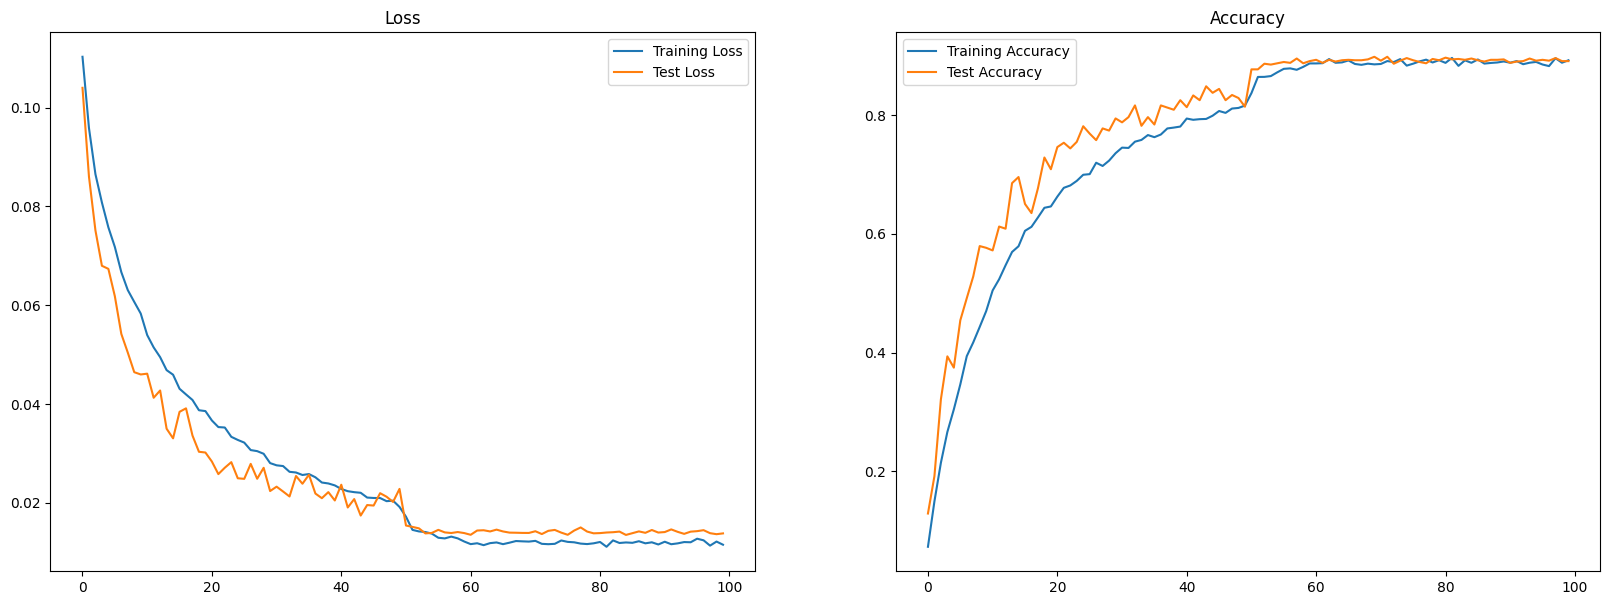

In [ ]:
plots=[(loss_hist,loss_hist_test),(acc_hist,acc_hist_test)]
plt_labels=[("Training Loss","Test Loss"),("Training Accuracy","Test Accuracy")]
plt_titles=["Loss","Accuracy"]
plt.figure(figsize=(20,7))
for i in range(0,2):
    ax=plt.subplot(1,2,i+1)
    ax.plot(plots[i][0],label=plt_labels[i][0])
    ax.plot(plots[i][1],label=plt_labels[i][1])
    ax.set_title(plt_titles[i])
    ax.legend()

In [ ]:
# Selecting the best model
best_acc = max(acc_hist_test)
best_epoch = acc_hist_test.index(best_acc)+1

print("Best accuracy on test set: {:.2f}%".format(best_acc*100))
print("Best epoch: {}".format(best_epoch))

# Load the best model
with open(f"Models/shuffleNetv2_model_{best_epoch}.pth","rb") as f:
    model=pickle.load(f)


Best accuracy on test set: 89.83%
Best epoch: 70


In [ ]:
pred_vec = []
label_vec = []
correct = 0
test_loss = 0.0
avg_test_loss = 0.0

model.to(device)
model.eval()
with torch.no_grad():
    for data in test_loader:
        batch, labels = data
        batch, labels = batch.to(device), labels.to(device)
        outputs = model(batch)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        test_loss += loss.item()
        pred_vec.extend(predicted.cpu().numpy())  # Convert tensor to numpy array
        label_vec.extend(labels.cpu().numpy())  # Convert tensor to numpy array

    avg_test_loss = test_loss / len(test_set)

pred_vec = np.array(pred_vec)
label_vec = np.array(label_vec)


In [ ]:
print(F"Test Loss: {avg_test_loss}")
print(F"Test Accuracy on the {len(test_set)} test images: {(100 * correct / len(test_set))}%")

Test Loss: 0.013911387481847294
Test Accuracy on the 1367 test images: 89.83174835405998%


In [ ]:
torch.save(model.state_dict(), "model_weights.pth")

In [ ]:
# Create confusion matrix
from sklearn.metrics import confusion_matrix
confusion_mat = confusion_matrix(label_vec, pred_vec)
# Convert confusion matrix to pandas DataFrame
labels = np.unique(label_vec)
confusion_df = pd.DataFrame(confusion_mat, index=classes, columns=classes)
print("Confusion Matrix")
confusion_df

Confusion Matrix


云芝  冬菇  冬虫夏草  出血齿菌  变绿红菇  大青褶伞  大鹿花菌  宽鳞多孔菌  尾花笼头菌  干巴菌  ...  羊肚菌  \
云芝       26   0     0     0     0     0     0      0      0    3  ...    0   
冬菇        0  27     1     0     0     0     0      0      0    0  ...    0   
冬虫夏草      0   0    53     0     0     0     0      0      0    0  ...    0   
出血齿菌      0   0     0    30     0     0     0      0      0    0  ...    0   
变绿红菇      0   0     0     0    30     0     0      0      0    0  ...    0   
大青褶伞      0   0     0     0     0    25     0      0      0    0  ...    0   
大鹿花菌      0   0     0     0     0     0    30      0      0    0  ...    0   
宽鳞多孔菌     1   0     0     0     0     0     0     23      0    0  ...    0   
尾花笼头菌     0   0     0     0     0     0     0      0     29    0  ...    0   
干巴菌       0   0     0     0     0     0     0      0      0   29  ...    0   
恶魔雪茄蘑菇    0   0     0     0     0     0     0      0      2    0  ...    0   
杏鮑菇       0   0     0     0     0     0     0      0      0    0  ...    0   
欧洲黑木耳     2   3     0     0     0     0     0      0      0    0  ...    0   
毒丝盖伞      0   3     0     0     0     0     0      0      0    0  ...    0   
毒蕈        0   0     0     0     0     0     0      2      0    0  ...    0   
毒蝇伞       0   0     0     0     0     0     0      0      0    0  ...    0   
毛头鬼伞      0   0     0     0     0     0     0      0      0    0  ...    0   
灵芝        0   0     1     1     0     0     0      0      0    0  ...    0   
牛舌菌       0   0     0     0     0     0     0      1      0    0  ...    0   
狭头小菇      0   0     0     0     0     0     0      0      0    0  ...    0   
猴头菇       0   0     1     0     0     0     0      0      0    0  ...    0   
硫黄菌       1   0     1     0     0     0     0      0      0    0  ...    0   
竹荪        0   0     0     0     0     0     0      0      0    0  ...    0   
粉红枝瑚菌     0   0     1     0     0     0     0      0      0    0  ...    0   
粪生黑蛋巢菌    0   0     0     0     0     0     0      0      0    2  ...    0   
紫蜡蘑       0   0     0     0     0     0     0      0      0    0  ...    0   
綠蓋粉孢牛肝菌   0   0     0     0     0     0     0      1      0    0  ...    0   
红笼头菌      0   0     0     0     0     0     0      0      1    0  ...    0   
红紫柄小菇     0   0     0     0     0     0     0      0      0    0  ...    0   
细褐鳞蘑菇     0   0     0     0     0     1     0      0      0    0  ...    0   
羊肚菌       0   0     0     0     0     0     0      0      0    0  ...   33   
美味牛肝菌     0   0     0     0     0     0     0      0      0    0  ...    0   
蓝绿乳菇      0   0     0     0     0     0     0      0      0    0  ...    0   
裂褶菌       0   0     0     0     0     1     0      0      0    0  ...    0   
赭红拟口蘑     0   0     0     0     1     1     0      0      0    0  ...    0   
金黃鵝膏菌     0   0     0     0     0     0     0      0      0    0  ...    0   
鳞柄白鹅膏     0   0     0     0     0     1     0      0      0    0  ...    0   
鹿蕊        0   0     0     0     0     0     0      0      0    0  ...    0   
黄裙竹荪      0   0     0     0     0     0     0      0      0    0  ...    0   
黑松露       0   0     0     0     0     0     0      0      0    0  ...    1   

         美味牛肝菌  蓝绿乳菇  裂褶菌  赭红拟口蘑  金黃鵝膏菌  鳞柄白鹅膏  鹿蕊  黄裙竹荪  黑松露  
云芝           0     0    0      0      0      0   0     0    0  
冬菇           0     0    1      1      0      0   0     0    0  
冬虫夏草         0     0    0      0      0      0   0     0    0  
出血齿菌         0     0    0      0      0      0   0     0    0  
变绿红菇         0     0    0      0      0      0   0     0    0  
大青褶伞         0     0    0      0      0      4   0     0    0  
大鹿花菌         0     0    0      0      0      0   0     0    0  
宽鳞多孔菌        0     0    1      0      0      0   0     0    0  
尾花笼头菌        0     0    0      0      0      0   0     1    0  
干巴菌          0     1    0      0      0      0   0     0    0  
恶魔雪茄蘑菇       0     0    0      0      0      0   0     0    0  
杏鮑菇          0     0    0      0      0   

In [ ]:
# Create a report to show the f1-score, precision, recall
from sklearn.metrics import classification_report

report = pd.DataFrame.from_dict(classification_report(pred_vec,label_vec,output_dict=True)).T
report['Label']=[classes[int(x)] if x.isdigit() else " " for x in report.index]
report=report[['Label','f1-score','precision','recall','support']]
report

Label  f1-score  precision    recall      support
0                  云芝  0.866667   0.866667  0.866667    30.000000
1                  冬菇  0.794118   0.771429  0.818182    33.000000
2                冬虫夏草  0.938053   0.963636  0.913793    58.000000
3                出血齿菌  0.983607   1.000000  0.967742    31.000000
4                变绿红菇  0.983607   1.000000  0.967742    31.000000
5                大青褶伞  0.847458   0.833333  0.862069    29.000000
6                大鹿花菌  1.000000   1.000000  1.000000    30.000000
7               宽鳞多孔菌  0.884615   0.920000  0.851852    27.000000
8               尾花笼头菌  0.935484   0.966667  0.906250    32.000000
9                 干巴菌  0.906250   0.966667  0.852941    34.000000
10             恶魔雪茄蘑菇  0.857143   0.807692  0.913043    23.000000
11                杏鮑菇  0.915254   0.900000  0.931034    29.000000
12              欧洲黑木耳  0.842105   0.800000  0.888889    27.000000
13               毒丝盖伞  0.923729   0.908333  0.939655   116.000000
14                 毒蕈  0.793651   0.833333  0.757576    33.000000
15                毒蝇伞  0.967742   1.000000  0.937500    32.000000
16               毛头鬼伞  1.000000   1.000000  1.000000    30.000000
17                 灵芝  0.826667   0.775000  0.885714    35.000000
18                牛舌菌  0.800000   0.733333  0.880000    25.000000
19               狭头小菇  0.831169   1.000000  0.711111    45.000000
20                猴头菇  0.892308   0.966667  0.828571    35.000000
21                硫黄菌  0.885246   0.900000  0.870968    31.000000
22                 竹荪  0.838710   0.866667  0.812500    32.000000
23              粉红枝瑚菌  0.957746   0.971429  0.944444    36.000000
24             粪生黑蛋巢菌  0.927536   0.914286  0.941176    34.000000
25                紫蜡蘑  0.937500   0.937500  0.937500    32.000000
26            綠蓋粉孢牛肝菌  0.800000   0.750000  0.857143    21.000000
27               红笼头菌  0.983051   0.966667  1.000000    29.000000
28              红紫柄小菇  0.873950   0.787879  0.981132    53.000000
29              细褐鳞蘑菇  0.779661   0.766667  0.793103    29.000000
30                羊肚菌  0.985075   1.000000  0.970588    34.000000
31              美味牛肝菌  0.866667   0.866667  0.866667    30.000000
32               蓝绿乳菇  0.967742   1.000000  0.937500    32.000000
33                裂褶菌  0.866667   0.866667  0.866667    30.000000
34              赭红拟口蘑  0.745098   0.655172  0.863636    22.000000
35              金黃鵝膏菌  0.952381   1.000000  0.909091    33.000000
36              鳞柄白鹅膏  0.875000   0.933333  0.823529    34.000000
37                 鹿蕊  0.967742   1.000000  0.937500    32.000000
38               黄裙竹荪  0.847458   0.833333  0.862069    29.000000
39                黑松露  0.949153   0.933333  0.965517    29.000000
accuracy               0.898317   0.898317  0.898317     0.898317
macro avg              0.894900   0.899059  0.895527  1367.000000
weighted avg           0.899277   0.905220  0.898317  1367.000000

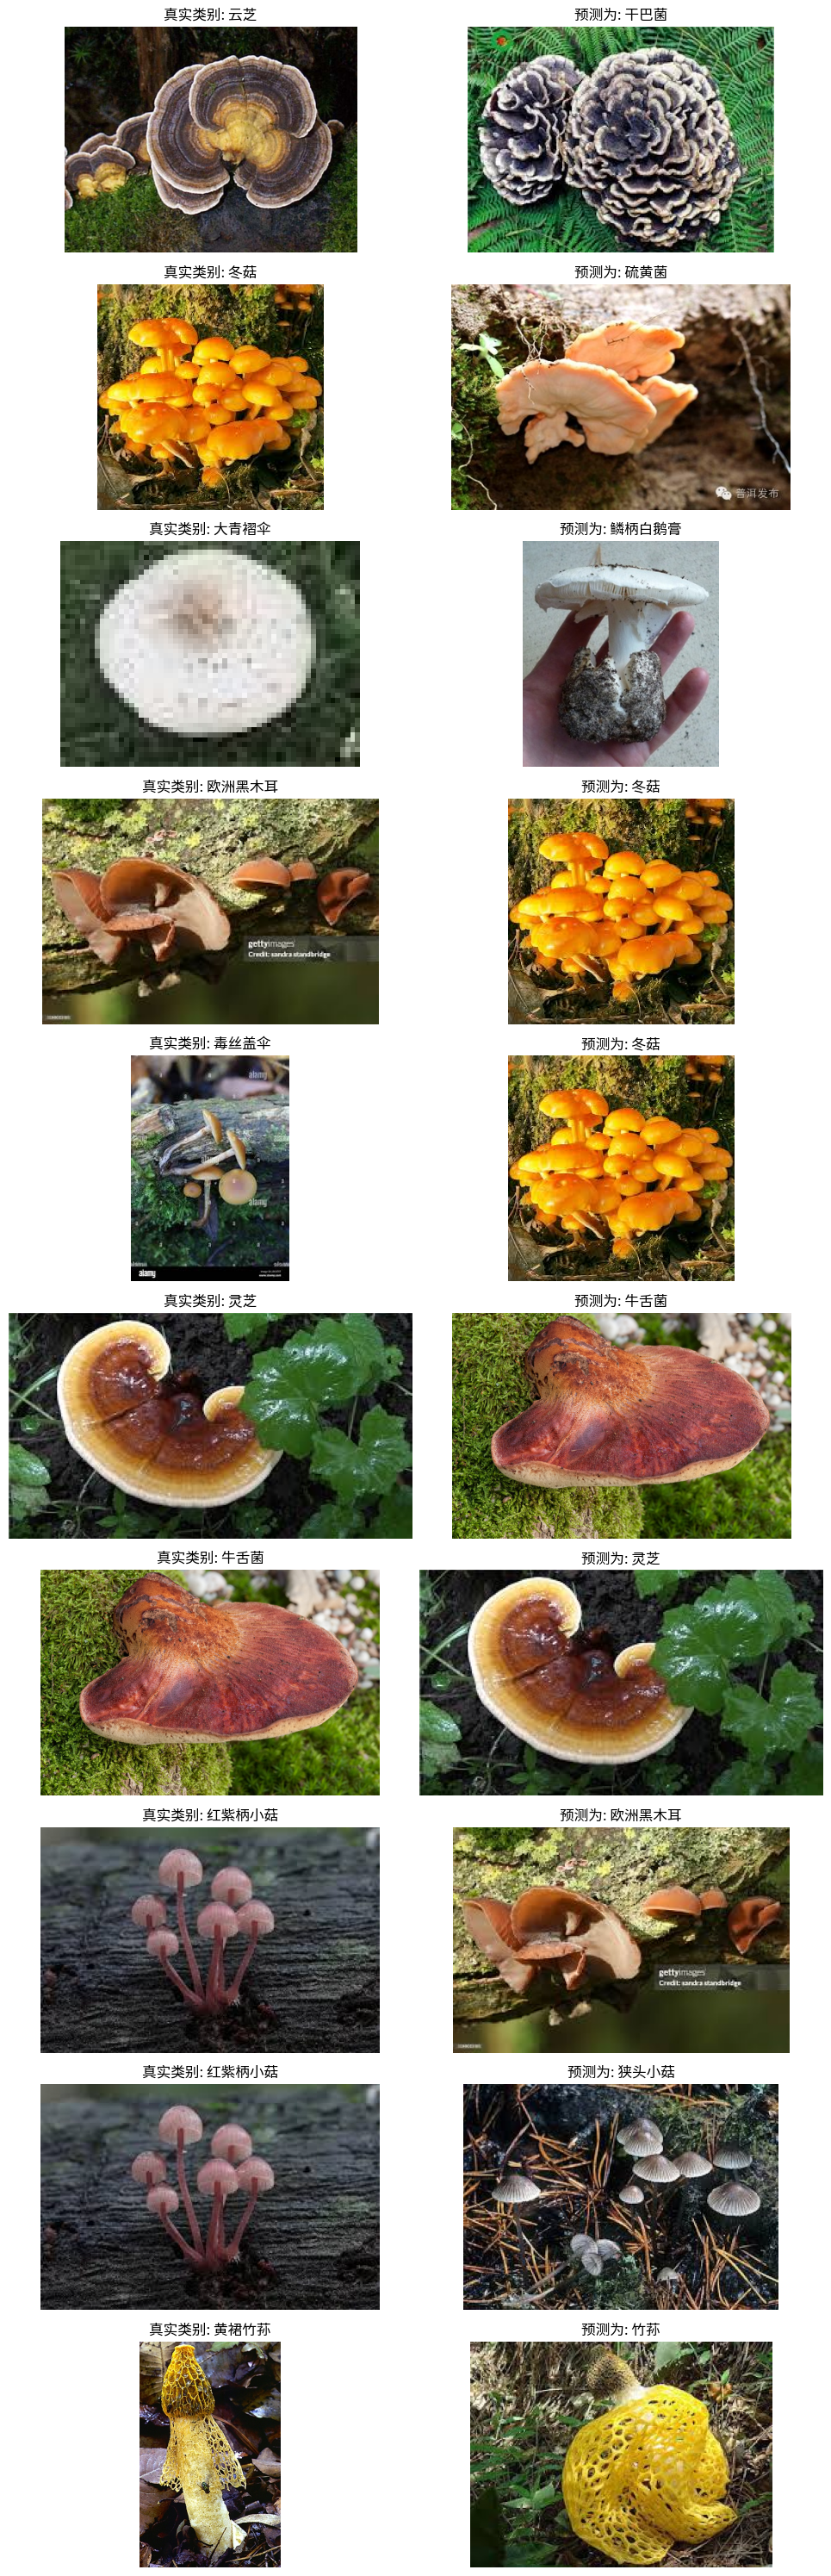

In [ ]:

# 使用提供的蘑菇类别名称列表
classes = [
    '云芝', '冬菇', '冬虫夏草','出血齿菌', '变绿红菇', '大青褶伞', '大鹿花菌', '宽鳞多孔菌',
    '尾花笼头菌', '干巴菌','恶魔雪茄蘑菇', '杏鮑菇', '欧洲黑木耳','毒丝盖伞', '毒蕈', '毒蝇伞', '毛头鬼伞',
    '灵芝','牛舌菌', '狭头小菇', '猴头菇', '硫黄菌', '竹荪', '粉红枝瑚菌', '粪生黑蛋巢菌',
    '紫蜡蘑','綠蓋粉孢牛肝菌', '红笼头菌', '红紫柄小菇' ,'细褐鳞蘑菇', '羊肚菌', '美味牛肝菌','蓝绿乳菇', '裂褶菌',
    '赭红拟口蘑', '金黃鵝膏菌','鳞柄白鹅膏','鹿蕊', '黄裙竹荪', '黑松露'
]

# 生成混淆矩阵
confusion_mat = confusion_matrix(label_vec, pred_vec)
labels = np.unique(label_vec)

# 转换为 DataFrame
confusion_df = pd.DataFrame(confusion_mat, index=labels, columns=labels)

# 找到所有易混淆的类别对
threshold = 2  # 误分类次数阈值，可调小以增加混淆对数
confused_pairs = []
for i in range(len(labels)):
    for j in range(len(labels)):
        if i != j and confusion_df.iloc[i, j] > threshold:
            confused_pairs.append((labels[i], labels[j], confusion_df.iloc[i, j]))

# 从 train_set 中找到对应类别的图像样本
sample_images = []
for label in range(len(classes)):
    for path, target in train_set.imgs:
        if target == label:
            img = Image.open(path).convert("RGB")  # 转换为 RGB 格式
            sample_images.append((img, classes[label]))  # 用中文名作为标签
            break

# 检查是否有符合条件的混淆类别对
num_pairs = len(confused_pairs)

if num_pairs > 0:
    # 处理单个配对的情况
    if num_pairs == 1:
        fig, axes = plt.subplots(1, 2, figsize=(10, 3))
        axes = np.array([axes])  # 将 axes 转换为二维数组，方便统一处理
    else:
        fig, axes = plt.subplots(num_pairs, 2, figsize=(10, 3 * num_pairs))

    for i, (label1, label2, _) in enumerate(confused_pairs):
        # 获取每个类别的图像和标签
        img1, label_name1 = sample_images[label1]
        img2, label_name2 = sample_images[label2]

        # 左侧：真实类别
        axes[i, 0].imshow(img1)
        axes[i, 0].set_title(f"真实类别: {label_name1}", fontproperties=font_prop, fontsize=12)
        axes[i, 0].axis('off')

        # 右侧：预测类别
        axes[i, 1].imshow(img2)
        axes[i, 1].set_title(f"预测为: {label_name2}", fontproperties=font_prop, fontsize=12)
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("没有符合条件的混淆类别对。")


In [ ]:

# 用于跟踪每个类别是否已展示过
displayed_classes = {}
fig, axes = plt.subplots(8, 5, figsize=(15, 15))  # 创建8x5网格，展示40张图片
model.cpu()

# 遍历测试数据加载器
idx = 0
for images, labels in test_loader:
    if len(displayed_classes) == num_classes:  # 如果已展示所有类别，停止遍历
        break

    # 获取模型的输出并得到预测类别
    output = model(images)
    _, preds = torch.max(output, 1)

    for img, label, pred in zip(images, labels, preds):
        label_item = label.item()
        if label_item not in displayed_classes:
            # 归一化图像张量到[0, 1]范围
            image = img.permute(1, 2, 0)
            image = (image - image.min()) / (image.max() - image.min())

            ax = axes.flat[idx]
            ax.imshow(image)
            ax.axis('off')
            # 设置标题并应用中文字体
            ax.set_title("{}".format(classes[label_item]),
                         fontproperties=font_prop,
                         color=("green" if pred == label else "red"))

            displayed_classes[label_item] = True  # 标记该类别已展示
            idx += 1

            if idx == num_classes:  # 如果已满 8x5 网格，停止展示
                break

plt.show()



In [ ]:
model_path = '/content/drive/MyDrive/Colab Notebooks/My models/saved_model.pth'

# Step 3: 加载模型
# 确保你使用的模型架构和保存模型时的一致
model = torch.load(model_path)
model.eval()  # 设置模型为评估模式

print("Model loaded successfully from Google Drive!")

<ipython-input-23-829f631764ab>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)


Model loaded successfully from Google Drive!


In [ ]:
import os
import torch
from google.colab import drive

# Step 1: 挂载 Google Drive
drive.mount('/content/drive')

# 指定保存路径
save_directory = '/content/drive/MyDrive/Colab Notebooks/My models'
save_path = os.path.join(save_directory, 'saved_model.pth')

# 确保保存路径存在，如果不存在则创建
os.makedirs(save_directory, exist_ok=True)

# 保存整个模型
torch.save(model, save_path)
print(f'Model saved to {save_path}')

# Step 2: 从保存路径重新加载模型
loaded_model = torch.load(save_path)
loaded_model.eval()

print('Model loaded successfully from Google Drive')

